# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 44.457 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 44.457 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 69.215 MiB RAM in 0.743s, peaked 4.176 MiB above current, total RAM usage 113.672 MiB


In [4]:
movies.dtypes

movie_id     int64
title       object
genres      object
dtype: object

In [4] used 0.469 MiB RAM in 0.017s, peaked 0.000 MiB above current, total RAM usage 114.141 MiB


In [5]:
lens = pd.merge(movies, ratings)

In [5] used 54.793 MiB RAM in 0.114s, peaked 12.719 MiB above current, total RAM usage 168.934 MiB


In [6]:
size_pandas = mw.measurements.memory_delta
size_pandas

54.79296875

In [6] used 0.051 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 168.984 MiB


In [7]:
# pandas also comes with its own tool for getting memory usage
print(lens.memory_usage())

Index             8001672
movie_id          8001672
title             8001672
genres            8001672
user_id           8001672
rating            8001672
unix_timestamp    8001672
dtype: int64
In [7] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 168.984 MiB


### Exercise

1) Why do you think that the size is the same for every column in the dataframe?

*Hint:* pandas stores the string columns in NumPy containers with 'object' dtype.

2) Provided how the `lens` DataFrame looks like:

In [8]:
lens.head()

,movie_id,title,genres,user_id,rating,unix_timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [8] used 0.000 MiB RAM in 0.024s, peaked 0.000 MiB above current, total RAM usage 168.984 MiB


In [9]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [9] used 24.570 MiB RAM in 0.173s, peaked 0.000 MiB above current, total RAM usage 193.555 MiB


Do you think this is all the memory that the DataFrame tables?

### Solution

In [10]:
# Use deep=True for including the size of the object types
print(lens.memory_usage(deep=True))

Index              8001672
movie_id           8001672
title             80347206
genres            71665151
user_id            8001672
rating             8001672
unix_timestamp     8001672
dtype: int64
In [10] used 0.004 MiB RAM in 0.327s, peaked 0.000 MiB above current, total RAM usage 193.559 MiB


In [11]:
# For a more realistic memory usage, we are going to use deep=True
size_pandas2 = lens.memory_usage(deep=True).sum() / 2**20.
size_pandas2

183.12522602081299

In [11] used 0.023 MiB RAM in 0.247s, peaked 0.000 MiB above current, total RAM usage 193.582 MiB


## Querying a pandas DataFrame

In [46]:
# Let's do a typical query in pandas and see how fast it can be
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 51.5 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [46] used 0.215 MiB RAM in 2.260s, peaked 0.000 MiB above current, total RAM usage 1216.152 MiB


In [13]:
# Store it for future reference
qtime_pandas = t.best

In [13] used 0.020 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 194.066 MiB


## Use a compressed in-memory container via `bcolz`

In [14]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 9
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE  # try with NOSHUFFLE and BITSHUFFLE as well
bcolz.set_nthreads(1)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.1.1.dev20
NumPy version:     1.11.0
Blosc version:     1.9.3 ($Date:: 2016-07-06 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.5.2
Dask version:      0.9.0
Python version:    3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [14] used 6.910 MiB RAM in 0.151s, peaked 0.000 MiB above current, total RAM usage 200.977 MiB


In [15]:
zlens = bcolz.ctable.fromdataframe(lens)

In [15] used 0.812 MiB RAM in 1.188s, peaked 312.836 MiB above current, total RAM usage 201.789 MiB


In [16]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', '<U82'), ('genres', '<U47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 522.72 MB; cbytes: 10.75 MB; ratio: 48.65
  cparams := cparams(clevel=9, shuffle=2, cname='lz4', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [16] used 0.008 MiB RAM in 0.023s, peaked 0.000 MiB above current, total RAM usage 201.797 MiB


In [17]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.0078125

In [17] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 201.797 MiB


We see that the reported memory consumption is *really* low, so let's take the internal estimation for comparison purposes.

In [18]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', '<U82'), ('genres', '<U47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 522.72 MB; cbytes: 10.75 MB; ratio: 48.65
  cparams := cparams(clevel=9, shuffle=2, cname='lz4', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [18] used 0.000 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 201.797 MiB


In [19]:
size_bcolz2 = zlens.cbytes / 2**20.

In [19] used 2.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 203.797 MiB


In [20]:
size_pandas2 / size_bcolz2

17.041883453903484

In [20] used -1.965 MiB RAM in 0.004s, peaked 1.965 MiB above current, total RAM usage 201.832 MiB


## Querying a bcolz ctable

In [21]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
zlens.delcol('title')
zlens.addcol(title, 'title')

In [21] used 78.230 MiB RAM in 0.461s, peaked 0.000 MiB above current, total RAM usage 280.062 MiB


In [22]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
genre = zlens['genres'][:].astype('S47')
zlens.delcol('genres')
zlens.addcol(genre, 'genres')

In [22] used -33.375 MiB RAM in 0.270s, peaked 33.375 MiB above current, total RAM usage 246.688 MiB


We can see that the space taken by a bcolz container is around 20x smaller (!) than a pandas one.

In [23]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 40.7 ms per loop
In [23] used 5.109 MiB RAM in 1.840s, peaked 0.000 MiB above current, total RAM usage 251.797 MiB


In [24]:
qtime_bcolz = t.best

In [24] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 251.797 MiB


In [25]:
qtime_pandas / qtime_bcolz

1.2105724532021065

In [25] used 0.020 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 251.816 MiB


We see that by using a compressed bcolz container, it provides similar query times than pandas.

In [26]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

results with pandas Dataframe: 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64
results with bcolz ctable: [(5121, 75), (5164, 3842), (5187, 6031)]
In [26] used 2.070 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 253.887 MiB


## Use a *uncompressed* in-memory container via `bcolz`

So, what happens when we use an uncompressed container in bcolz?  We do expect better speed?  If so, how much?  Let's measure:

In [27]:
bcolz.defaults.cparams['clevel'] = 0

In [27] used -1.965 MiB RAM in 0.002s, peaked 1.965 MiB above current, total RAM usage 251.922 MiB


In [28]:
uzlens = bcolz.ctable.fromdataframe(lens)
uzlens

ctable((1000209,), [('movie_id', '<i8'), ('title', '<U82'), ('genres', '<U47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 522.72 MB; cbytes: 523.91 MB; ratio: 1.00
  cparams := cparams(clevel=0, shuffle=2, cname='lz4', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [28] used 997.703 MiB RAM in 0.989s, peaked 80.031 MiB above current, total RAM usage 1249.625 MiB


In [29]:
size_ubcolz = mw.measurements.memory_delta
size_ubcolz

997.703125

In [29] used 0.090 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 1249.715 MiB


In [30]:
size_ubcolz2 = uzlens.cbytes / 2**20.
size_ubcolz2

523.9061889648438

In [30] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 1249.715 MiB


In [31]:
size_pandas2 / size_ubcolz2

0.34953819954415816

In [31] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 1249.715 MiB


We can see that the space taken by an uncompressed bcolz container is very close to a pandas one (but keep an eye on the reported memory usage by memory_watcher).

In [32]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
uzlens.delcol('title')
uzlens.addcol(title, 'title')

In [32] used -44.730 MiB RAM in 0.064s, peaked 44.730 MiB above current, total RAM usage 1204.984 MiB


In [33]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 26.1 ms per loop
In [33] used 0.000 MiB RAM in 1.163s, peaked 0.000 MiB above current, total RAM usage 1204.984 MiB


In [34]:
qtime_ubcolz = t.best

In [34] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1204.984 MiB


In [35]:
qtime_pandas / qtime_ubcolz

1.8854051716231262

In [35] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 1204.984 MiB


## Using structured NumPy arrays

In [36]:
nalens = zlens[:]

In [36] used 0.000 MiB RAM in 0.176s, peaked 0.000 MiB above current, total RAM usage 1204.984 MiB


In [37]:
size_numpy = mw.measurements.memory_delta
size_numpy

0.0

In [37] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 1204.984 MiB


In [38]:
nalens

array([(1, 1, 5, 978824268, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 6, 4, 978237008, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 8, 4, 978233496, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       ...,
       (3952, 5837, 4, 1011902656, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5927, 1, 979852537, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5998, 4, 1001781044, b'Contender, The (2000)', b'Drama|Thriller')], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [38] used 2.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 1206.984 MiB


In [39]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

153.574

In [39] used -1.977 MiB RAM in 0.004s, peaked 1.977 MiB above current, total RAM usage 1205.008 MiB


In [40]:
# But, again, this does not account for 'O'bject dtypes, which are stored in its own storage area
# So, let's take this into account
import sys
size_numpy3 = size_numpy2 + round(sum(sum(sys.getsizeof(o) for o in nalens[col]) for col in ('title', 'genres')) // 2**20., 3)
size_numpy3

301.574

In [40] used 0.090 MiB RAM in 1.436s, peaked 0.000 MiB above current, total RAM usage 1205.098 MiB


In [41]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 12.5 ms per loop


array([], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [41] used -0.016 MiB RAM in 5.554s, peaked 0.016 MiB above current, total RAM usage 1205.082 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas (a hair less actually).

In [42]:
qtime_numpy = t.best

In [42] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1205.082 MiB


## Performance comparsion

In [43]:
%matplotlib inline

In [43] used 4.566 MiB RAM in 0.125s, peaked 0.000 MiB above current, total RAM usage 1209.648 MiB


/home/faltet/miniconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/faltet/miniconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


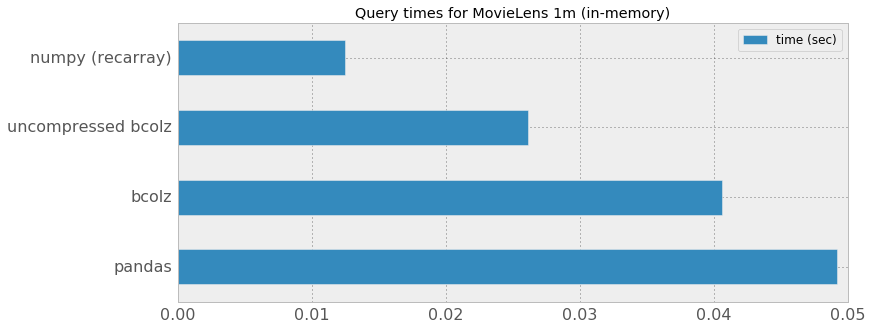

In [44] used 5.867 MiB RAM in 0.329s, peaked 0.000 MiB above current, total RAM usage 1215.516 MiB


In [44]:
# Query times
labels = ["pandas", "bcolz", "uncompressed bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_ubcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

/home/faltet/miniconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


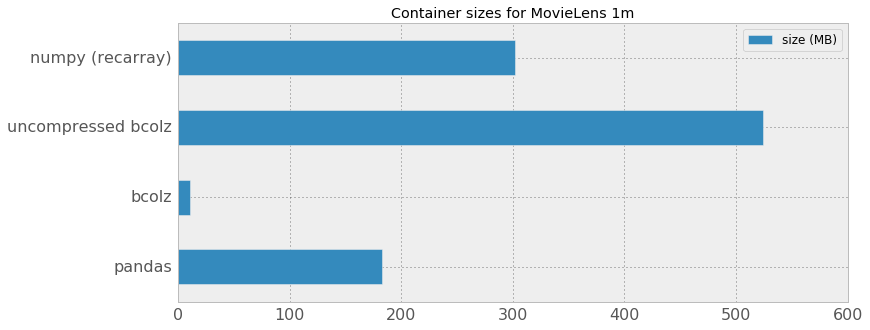

In [45] used 0.422 MiB RAM in 0.244s, peaked 0.000 MiB above current, total RAM usage 1215.938 MiB


In [45]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas2, size_bcolz2, size_ubcolz2, size_numpy3]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)